# Experiment with UNet Training

In [1]:
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch as th
import xarray as xr
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import draw_bounding_boxes
from xarray import DataArray

from rattlinbog.estimators.apply import apply
from rattlinbog.estimators.wetland_classifier import WetlandClassifier
from rattlinbog.io_xarray.store_as_compressed_zarr import store_as_compressed_zarr
from rattlinbog.persist.serialize_best_scoring_nn_model import SerializeBestScoringNNModel
from rattlinbog.pipeline.factory_functions import make_validation_log_cfg
from rattlinbog.pipeline.train import train
from rattlinbog.sampling.sample_patches_from_dataset import SamplingConfig, make_balanced_sample_indices_for
from rattlinbog.th_extensions.nn.unet import UNet
from rattlinbog.th_extensions.utils.dataset_splitters import GROUND_TRUTH_KEY, \
    PARAMS_KEY

RESAMPLE = False

## Data Loading

In [2]:
zarr_archive = Path("/data/wetland/mmean/V1M0R1/EQUI7_EU020M/E045N021T3/MEAN-SIG0-MONTH-MASK-corine-inland-marshes_20180101T000000_20180101T000000__CORINE-INLAND-MARSHES-ROI-0-0-15000-15000_E045N021T3_EU020M__.zarr")
wetland_ds = xr.open_zarr(zarr_archive, decode_coords='all')
tokens = zarr_archive.name.split('_')[0].split('-')
GT_TYPE = '-'.join(tokens[tokens.index('MASK') + 1:])
GT_TYPE

'corine-inland-marshes'

In [3]:
print(f"{wetland_ds[PARAMS_KEY][1].min().values.item()}, {wetland_ds[PARAMS_KEY][1].max().values.item()}")

-25.30000114440918, 20.899999618530273


In [4]:
train_ds = wetland_ds.isel(y=slice(0, 12000), x=slice(0, 15000))
valid_ds = wetland_ds.isel(y=slice(12000, 14000), x=slice(9000, 11000))
valid_ds[GROUND_TRUTH_KEY].min().values.item()

0.0

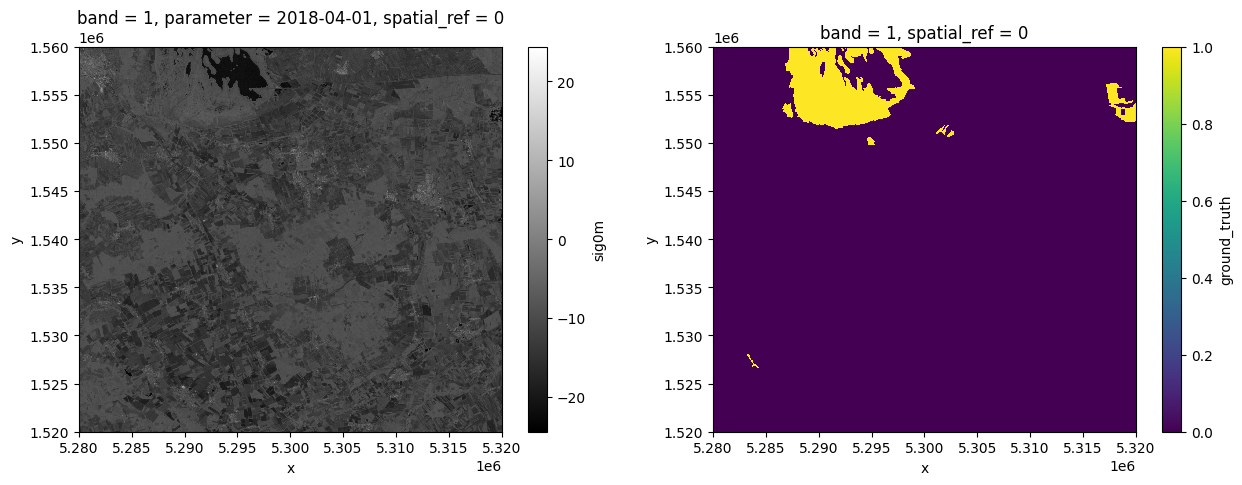

In [5]:
_, axes = plt.subplots(ncols=2, figsize=(15, 5))
valid_ds[PARAMS_KEY][3].plot.imshow(ax=axes[0], cmap='gray')
valid_ds[GROUND_TRUTH_KEY].plot(ax=axes[1])
plt.draw()

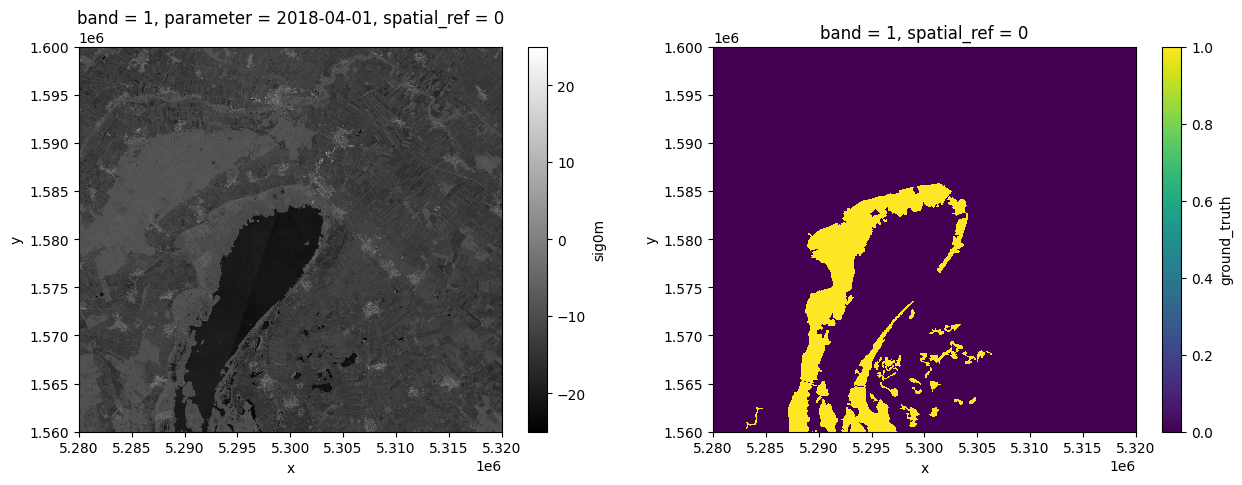

In [6]:
_, axes = plt.subplots(ncols=2, figsize=(15, 5))
train_ds[PARAMS_KEY][3, 10000:12000, 9000:11000].plot.imshow(ax=axes[0], cmap='gray')
train_ds[GROUND_TRUTH_KEY][10000:12000, 9000:11000].plot(ax=axes[1])
plt.draw()

In [7]:
cached_samples = Path(f"/data/wetland/samples/SPL-IDC_64_64000_NO-NANS_E051N015T3_ROI-0-0-12000-15000-{GT_TYPE}.zarr")

if RESAMPLE or not cached_samples.exists():
    sampling_cfg = SamplingConfig(patch_size=64, n_samples=64000, never_nans=True)
    sample_indices = make_balanced_sample_indices_for(train_ds, sampling_cfg)
    store_as_compressed_zarr(sample_indices.to_dataset(name='samples'), cached_samples)
else:
    sample_indices = xr.open_zarr(cached_samples)['samples'].load()

In [9]:
sample_indices = xr.open_zarr('/data/wetland/samples/V1M0R1/EQUI7_EU020M/E051N015T3/SPL-IDC-SIG0-HPAR-MASK____CORINE-INLAND-MARSHES-ROI-0-0-15000-15000_E051N015T3_EU020M__PS64-NS100000-OS2_SIG0-HPAR-MASK.zarr')['samples'].load()

## Train U-Net

In [8]:
unet = UNet(12, [128, 256, 512, 1024], 1).to(device=th.device('cuda'))

fit_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
train_writer = SummaryWriter(f"/data/runs/mmean/{GT_TYPE}/{fit_time}/train")
valid_writer = SummaryWriter(f"/data/runs/mmean/{GT_TYPE}/{fit_time}/valid")
model_out = Path(f'/data/wetland/models/mmean/{GT_TYPE}/{fit_time}')
model_out.mkdir(parents=True, exist_ok=True)
model_sink = SerializeBestScoringNNModel(model_out, score='F1')
log_cfg = make_validation_log_cfg(valid_ds, train_writer, valid_writer, 10, 20, model_sink)

estimator = WetlandClassifier(unet, batch_size=16, log_cfg=log_cfg)

In [9]:
train(estimator, train_ds, sample_indices, 64000)

fitting:   0%|                                | 10/4000 [00:09<30:13,  2.20it/s]/home/eouser/code/github/use-case-wetland-water-stress/rattlinbog/estimators/wetland_classifier.py:22: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/home/eouser/code/github/use-case-wetland-water-stress/rattlinbog/estimators/wetland_classifier.py:22: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
fitting:   0%|▏                               | 19/4000 [00:14<24:41,  2.69it/s]/home/eouser/code/github/use-case-wetland-water-stress/rattlinbog/estimators/wetland_classifier.py:22: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
fitting:  28%|████████▍                     | 1129/4000 [09:56<16:33,  2.89it/s]/home/eouser/code/github/use-case-wetland-water-stress/rattlinbog/estimators/wetland_classifier.py:22: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
fitting:  32%|█████████▌                    | 1269/4

WetlandClassifier(batch_size=16,
                  log_cfg=LogConfig(log_sink=<torch.utils.tensorboard.writer.SummaryWriter object at 0x7f9d15e9b4f0>,
                                    validation=ValidationLogging(log_sink=<torch.utils.tensorboard.writer.SummaryWriter object at 0x7f9d15e9b520>,
                                                                 source=<rattlinbog.evaluate.validation_source_from_dataset.ValidationSourceFromDataset object at 0x7f9d144ef400>,
                                                                 score...
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU()
        (cv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU()
      )
    )
    (RemoveSkips): RemoveSkips()
  )
  (_prediction): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
))

In [9]:
# estimator = WetlandClassifier.from_snapshot(Path('/data/wetland/models/mmean/2023-05-14_15-45-54/WetlandClassifier-F1-best.pt'), batch_size=16)

In [10]:
estimate = apply(estimator).to(valid_ds['params'])
estimate.min().values.item()

7.498686761494338e-31

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


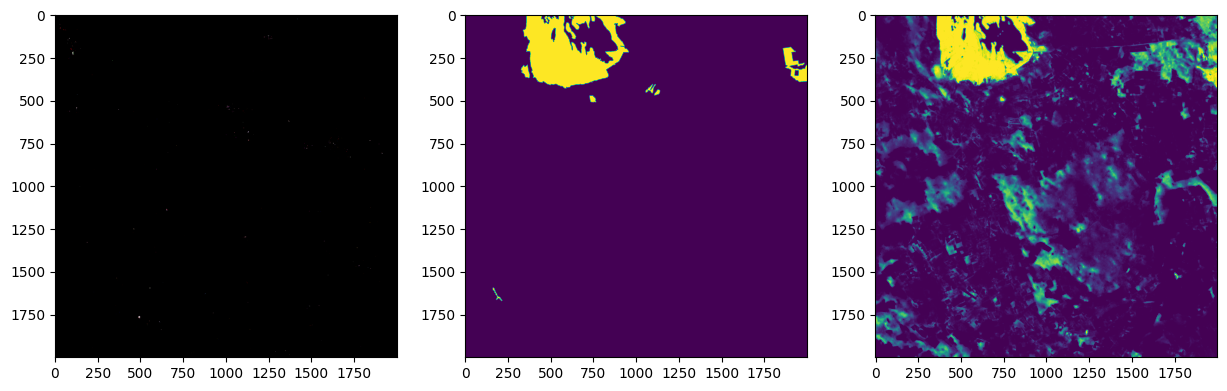

In [11]:
_, axes = plt.subplots(ncols=3, figsize=(15, 5))
axes[0].imshow(valid_ds[PARAMS_KEY][:3].values.transpose((1, 2, 0)))
axes[1].imshow(valid_ds[GROUND_TRUTH_KEY])
axes[2].imshow(estimate[0])
plt.draw()

In [20]:
def visualize_sample_boxes(bg, indices):
    bg = th.as_tensor(bg)
    cfg = SamplingConfig(**sample_indices.attrs)
    h2 = cfg.patch_size // 2
    rois = indices[::-1, ...]
    rois = np.concatenate([rois, rois])
    rois[:2] -= h2
    rois[2:] += h2
    rois = th.from_numpy(rois).permute(1, 0)
    return draw_bounding_boxes(bg, rois[:cfg.n_samples // 2], colors='#FFFFFF', fill=True), \
        draw_bounding_boxes(bg, rois[cfg.n_samples - (cfg.n_samples // 2):], colors='#FFFFFF', fill=True)


yes_boxes, no_boxes = visualize_sample_boxes(np.zeros((3,) + train_ds[GROUND_TRUTH_KEY].shape, dtype=np.uint8),
                                             sample_indices.values)

box_yes_tif = DataArray(np.asarray(yes_boxes[0]), dims=['y', 'x'],
                        coords={'y': train_ds.y, 'x': train_ds.x, 'spatial_ref': train_ds.spatial_ref})
box_yes_tif = box_yes_tif.rio.write_nodata(0)
box_yes_tif.rio.to_raster("/tmp/vis-boxes-yes.tif", compress='ZSTD')

box_no_tif = DataArray(np.asarray(no_boxes[0]), dims=['y', 'x'],
                       coords={'y': train_ds.y, 'x': train_ds.x, 'spatial_ref': train_ds.spatial_ref})
box_no_tif = box_no_tif.rio.write_nodata(0)
box_no_tif.rio.to_raster("/tmp/vis-boxes-no.tif", compress='ZSTD')

## Export Estimates

In [13]:
valid_estimate = estimate.rio.write_transform(valid_ds[GROUND_TRUTH_KEY].rio.transform())
valid_estimate = valid_estimate.rio.write_crs(valid_ds.spatial_ref.attrs['crs_wkt'])
valid_estimate = valid_estimate.where(valid_estimate>0.1, 0)
valid_estimate.rio.write_nodata(0, inplace=True)
valid_estimate[0].rio.to_raster("/tmp/valid-estimate.tif")

In [9]:
estimate_train = apply(estimator).to(train_ds['params'][:, 10000:12000, 9000:11000])

In [10]:
train_estimate = estimate_train.rio.write_transform(train_ds[GROUND_TRUTH_KEY].rio.transform())
train_estimate = train_estimate.rio.write_crs(train_ds.spatial_ref.attrs['crs_wkt']).load()

In [11]:
train_estimate_mask = train_estimate.where(train_estimate>0.1, 0)
train_estimate_mask = train_estimate_mask.rio.set_encoding(dict(dtype='uint8', _FillValue=255))
train_estimate_mask[0].rio.to_raster("/tmp/train-estimate-mask.tif", compress='ZSTD')

In [12]:
train_estimate_prob = train_estimate.rio.set_encoding(dict(scale_factor=0.01, dtype='int8', _FillValue=127))
train_estimate_prob[0].rio.to_raster("/tmp/train-estimate-prob-incomplete.tif", compress='ZSTD')

In [19]:
train_ds[GROUND_TRUTH_KEY].rio.to_raster("/tmp/train-mask-incomplete.tif", compress='ZSTD')

In [24]:
wetland_rgb_ds = wetland_ds[PARAMS_KEY].map_blocks(preprocess_rgb_comp, template=wetland_ds[PARAMS_KEY])

In [26]:
wetland_rgb_out = wetland_rgb_ds.rio.write_transform(wetland_ds[GROUND_TRUTH_KEY].rio.transform())
wetland_rgb_out = wetland_rgb_out.rio.write_crs(wetland_ds.spatial_ref.attrs['crs_wkt'])
wetland_rgb_out = wetland_rgb_out.rio.set_encoding(dict(scale_factor=0.01, dtype='uint8', _FillValue=255))
wetland_rgb_out.rio.to_raster('/tmp/rgb-composite.tif', compress='ZSTD')

In [16]:
estimate_all = apply(estimator).to(wetland_rgb_ds)

In [17]:
estimate_all = estimate_all.rio.write_crs(wetland_ds.spatial_ref.attrs['crs_wkt'])
estimate_all = estimate_all.where(estimate_all>0.1, 0)
estimate_all.rio.write_nodata(0, inplace=True)
estimate_all[0].rio.to_raster("/tmp/all-estimate.tif")